In [48]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np 
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

from aind_behavior_gym.dynamic_foraging.task import (CoupledBlockTask,
                                                     RandomWalkTask,
                                                     UncoupledBlockTask)
from aind_dynamic_foraging_models import generative_model
from aind_dynamic_foraging_models.generative_model import ForagerCollection
from aind_behavior_gym.dynamic_foraging.agent.random_agent import RandomAgent, RandomAgentBiasedIgnore
from aind_dynamic_foraging_models.generative_model.params import ParamsSymbols
from aind_dynamic_foraging_models.generative_model.params.util import get_params_options
from aind_dynamic_foraging_basic_analysis import compute_foraging_efficiency


sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/learning_dynamics_behavior/metric_dev/foraging_choice')
from foraging_choice import compute_foraging_choice


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
forager_collection = ForagerCollection()
df = forager_collection.get_all_foragers()
df.columns

Index(['agent_class_name', 'agent_kwargs', 'agent_alias',
       'number_of_learning_rate', 'number_of_forget_rate', 'choice_kernel',
       'action_selection', 'preset_name', 'n_free_params', 'params', 'forager',
       'win_stay_lose_switch'],
      dtype='object')

In [3]:
df[['agent_class_name', 'preset_name', 'n_free_params', 'params']]

,agent_class_name,preset_name,n_free_params,params
0,ForagerQLearning,None,3,"ParamsSymbols.learn_rate, ParamsSymbols.biasL,..."
1,ForagerQLearning,Rescorla-Wagner,3,"ParamsSymbols.learn_rate, ParamsSymbols.biasL,..."
2,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
3,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
4,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
5,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
6,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
7,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
8,ForagerQLearning,Bari2019,5,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
9,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."


In [4]:
df['params'].unique()

array(['ParamsSymbols.learn_rate, ParamsSymbols.biasL, ParamsSymbols.softmax_inverse_temperature',
       'ParamsSymbols.learn_rate, ParamsSymbols.biasL, ParamsSymbols.epsilon',
       'ParamsSymbols.learn_rate, ParamsSymbols.choice_kernel_step_size (fixed), ParamsSymbols.choice_kernel_relative_weight, ParamsSymbols.biasL, ParamsSymbols.softmax_inverse_temperature',
       'ParamsSymbols.learn_rate, ParamsSymbols.choice_kernel_step_size (fixed), ParamsSymbols.choice_kernel_relative_weight, ParamsSymbols.biasL, ParamsSymbols.epsilon',
       'ParamsSymbols.learn_rate, ParamsSymbols.choice_kernel_step_size, ParamsSymbols.choice_kernel_relative_weight, ParamsSymbols.biasL, ParamsSymbols.softmax_inverse_temperature',
       'ParamsSymbols.learn_rate, ParamsSymbols.choice_kernel_step_size, ParamsSymbols.choice_kernel_relative_weight, ParamsSymbols.biasL, ParamsSymbols.epsilon',
       'ParamsSymbols.learn_rate, ParamsSymbols.forget_rate_unchosen, ParamsSymbols.biasL, ParamsSymbols.softmax_i

In [5]:
# Initialize agent

forager = ForagerCollection().get_preset_forager('Hattori2019', seed=42)
forager.set_params(
    softmax_inverse_temperature=5,
    biasL=0
)

# Create task environment

task = CoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42)

In [6]:
forager.params

ParamsModel(learn_rate_rew=0.5, learn_rate_unrew=0.1, forget_rate_unchosen=0.2, biasL=0.0, softmax_inverse_temperature=5.0)

Foraging efficiency: 0.8078 (random seed: 0.801452784503632)
foraging_choice_local: 0.47841980626492875, (foraging_choice_global: 0.30826530612244896)


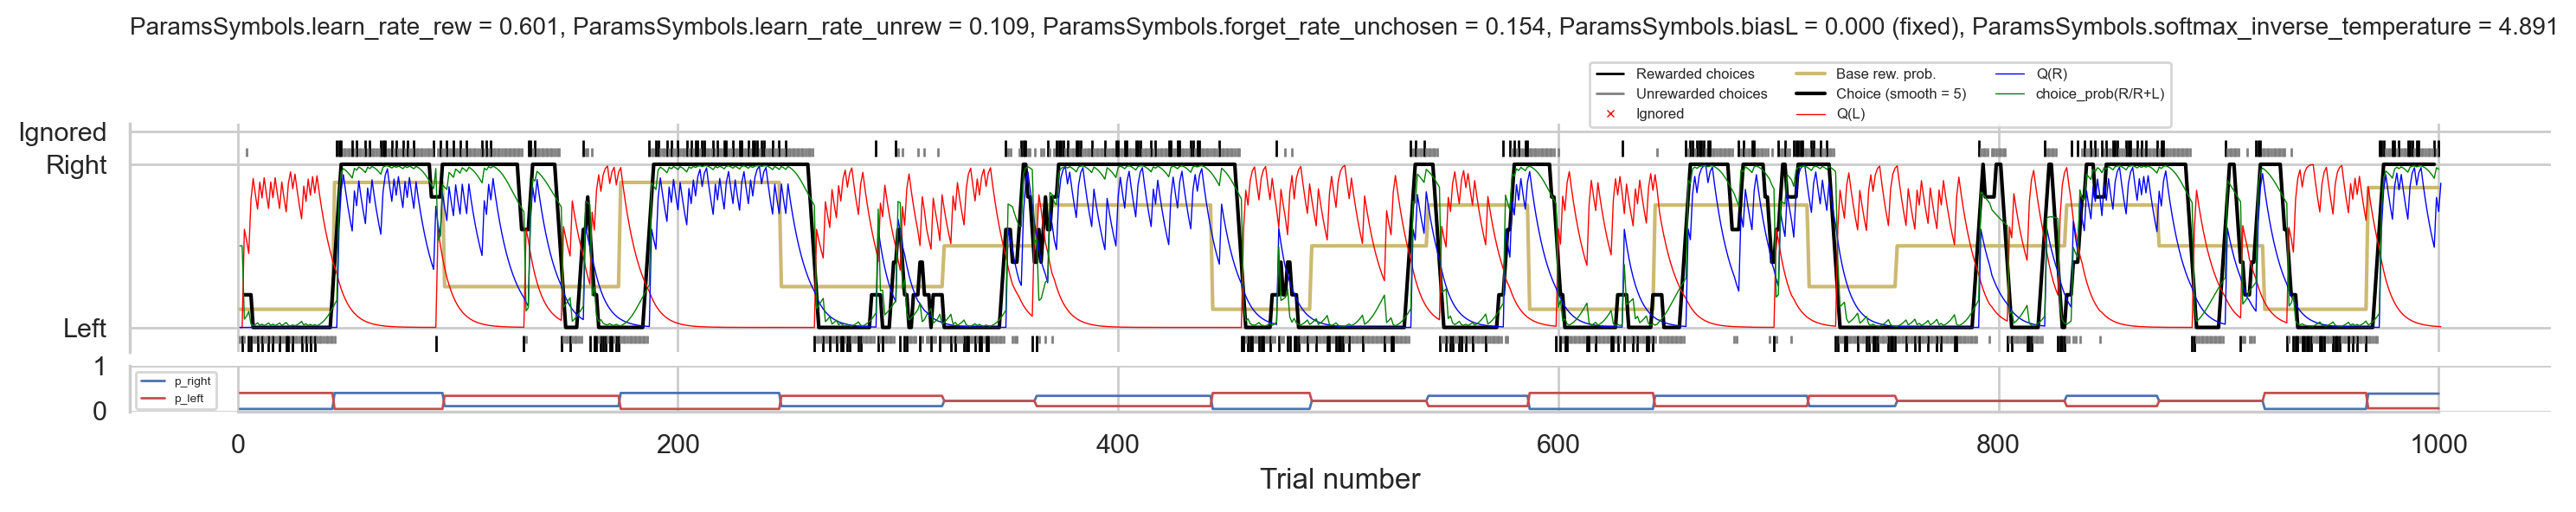

In [45]:
# Run the model
forager.perform(task)

# Get results
ground_truth_params = forager.params.model_dump()
ground_truth_choice_prob = forager.choice_prob
ground_truth_q_value = forager.q_value

# Evaluate the foraging efficiency
foraging_eff, foraging_eff_random_seed = compute_foraging_efficiency(
    baited=task.reward_baiting,
    choice_history=forager.get_choice_history(),
    reward_history=forager.get_reward_history(),
    p_reward=forager.get_p_reward(),
    random_number=task.random_numbers.T,
)

print(f"Foraging efficiency: {foraging_eff:.4f} (random seed: {foraging_eff_random_seed})")

foraging_choice_local, foraging_choice_global = compute_foraging_choice(
    choice_history=forager.get_choice_history(),
    reward_history=forager.get_reward_history(),
    p_reward=forager.get_p_reward(),
    global_calc=None
)

print(f'foraging_choice_local: {foraging_choice_local}, (foraging_choice_global: {foraging_choice_global})')

# Get history
choice_history = forager.get_choice_history()
reward_history = forager.get_reward_history()

# Plot session
fig, axes = forager.plot_session(if_plot_latent=True)

In [34]:
def run_model(n_iterations, task, forager):
    """
    Run model n_iterations and return foraging choice vector 
    """
    local_metrics = []
    global_metrics = []

    foraging_efficiency = []
    foraging_efficiency_random_seed = []

    for _ in range(n_iterations):
        # reset and run model
        forager.reset()
        forager.perform(task)

        # Calculate metrics
        local_metric, global_metric = compute_foraging_choice(
            choice_history=forager.get_choice_history(),
            reward_history=forager.get_reward_history(),
            p_reward=forager.get_p_reward(),
            global_calc=None
        )

        local_metrics.append(local_metric)
        global_metrics.append(global_metric)

        foraging_eff, foraging_eff_random_seed = compute_foraging_efficiency(
            baited=task.reward_baiting,
            choice_history=forager.get_choice_history(),
            reward_history=forager.get_reward_history(),
            p_reward=forager.get_p_reward(),
            random_number=task.random_numbers.T,
        )

        foraging_efficiency.append(foraging_eff)
        foraging_efficiency_random_seed.append(foraging_eff_random_seed)

    return np.array(local_metrics), np.array(global_metrics), np.array(foraging_efficiency), np.array(foraging_efficiency_random_seed)

In [35]:
n_iterations = 1000

local_metrics, global_metrics, foraging_efficiency, foraging_efficiency_random_seed = run_model(n_iterations, task, forager)


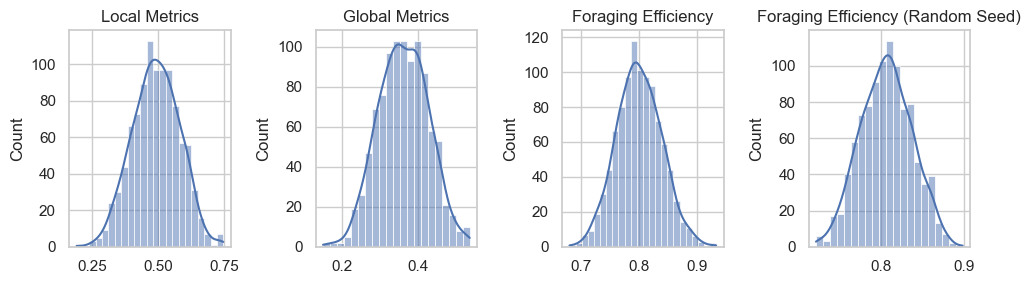

In [36]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 3))

sns.histplot(x=local_metrics, kde=True, ax=ax1, label='local_metric')
ax1.set_title('Local Metrics')

sns.histplot(x=global_metrics, kde=True, ax=ax2, label='global_metric')
ax2.set_title('Global Metrics')

sns.histplot(x=foraging_efficiency, kde=True, ax=ax3, label='foraging_efficiency')
ax3.set_title('Foraging Efficiency')

sns.histplot(x=foraging_efficiency_random_seed, kde=True, ax=ax4, label='foraging_efficiency_random_seed')
ax4.set_title('Foraging Efficiency (Random Seed)')

plt.tight_layout()


In [52]:
def param_sweep(tasks, foragers, param_ranges=None, n_repeats=1):
    """
    Sweep over learning rates for metric evaluation

    Params:
    tasks: dict of task environments 
    foragers: dict of forager agents
    param_ranges (dict, optional): dictionary of parameter names and ranges to sweep over, if None use default ranges
    n_repeats (int, optional): number of repeats to run for each parameter combination

    Returns:
    pd.DataFrame: DataFrame containing parameter combinations, task types, agent types, and metrics 
    """
    if param_ranges is None:
        param_ranges = {
            'learn_rate_rew': np.linspace(0.1, 0.9, 5),
            'learn_rate_unrew': np.linspace(0.05, 0.3, 5),
            'forget_rate_unchosen': np.linspace(0.05, 0.3, 5)
        }

    # Convert single instances to dict format
    if not isinstance(tasks, dict):
        tasks = {'default_task': tasks}
    if not isinstance(foragers, dict):
        foragers = {'default_agent': foragers}

    results = []

    # Fixed parameters
    fixed_params = {
        'softmax_inverse_temperature': 5,
        'biasL': 0
    }

    # Iterate through parameters 
    for lr_rew in param_ranges['learn_rate_rew']:
        for lr_unrew in param_ranges['learn_rate_unrew']:
            for fr_unchosen in param_ranges['forget_rate_unchosen']:
                # Set parameters
                params = {
                    'learn_rate_rew': lr_rew,
                    'learn_rate_unrew': lr_unrew,
                    'forget_rate_unchosen': fr_unchosen,
                    **fixed_params
                }

                # Iterate through task types
                for task_name, task in tasks.items():
                    # Iterate through forager types
                    for agent_name, forager in foragers.items():
                        # Repeat n times for each parameter combination
                        for repeat in range(n_repeats):
                            forager.reset()
                            forager.params = forager.params.model_copy(update=params)
                            forager.perform(task)

                            # Calculate metrics 
                            local_metric, global_metric = compute_foraging_choice(
                                choice_history=forager.get_choice_history(),
                                reward_history=forager.get_reward_history(),
                                p_reward=forager.get_p_reward(),
                                global_calc=None
                            )

                            foraging_eff, foraging_eff_random_seed = compute_foraging_efficiency(
                                baited=task.reward_baiting,
                                choice_history=forager.get_choice_history(),
                                reward_history=forager.get_reward_history(),
                                p_reward=forager.get_p_reward(),
                                random_number=task.random_numbers.T,
                            )

                            # Store results
                            results.append({
                                'task_type': task_name,
                                'agent_type': agent_name,
                                'repeat': repeat,
                                'learn_rate_rew': lr_rew,
                                'learn_rate_unrew': lr_unrew,
                                'forget_rate_unchosen': fr_unchosen,
                                'local_metric': local_metric,
                                'global_metric': global_metric,
                                'foraging_efficiency': foraging_eff,
                                'foraging_efficiency_random_seed': foraging_eff_random_seed
                            })

    return pd.DataFrame(results)


In [53]:
# Set parameter and condition ranges

tasks = {
    'coupled_baited': CoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42),
    'coupled_unbaited': CoupledBlockTask(reward_baiting=False, num_trials=1000, seed=42),
    'uncoupled_baited': UncoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42),
    'uncoupled_unbaited': UncoupledBlockTask(reward_baiting=False, num_trials=1000, seed=42)
}

foragers = {
    'Hattori2019': ForagerCollection().get_preset_forager('Hattori2019', seed=42)
    }

custom_ranges = {
    'learn_rate_rew': np.linspace(0.01, 2, 30),
    'learn_rate_unrew': np.linspace(0.01, 2, 30),
    'forget_rate_unchosen': np.linspace(0.01, 2, 30)
}
# Run the parameter sweep
results_df = param_sweep(tasks, foragers, custom_ranges)

In [55]:
results_df

,task_type,agent_type,repeat,learn_rate_rew,learn_rate_unrew,forget_rate_unchosen,local_metric,global_metric,foraging_efficiency,foraging_efficiency_random_seed
0,coupled_baited,Hattori2019,0,0.01,0.01,0.010000,0.016463,0.021459,0.901640,0.906863
1,coupled_unbaited,Hattori2019,0,0.01,0.01,0.010000,-0.032918,0.002214,0.688643,0.673591
2,uncoupled_baited,Hattori2019,0,0.01,0.01,0.010000,0.050630,0.018500,0.780918,0.792929
3,uncoupled_unbaited,Hattori2019,0,0.01,0.01,0.010000,0.135837,0.010500,0.724784,0.736457
4,coupled_baited,Hattori2019,0,0.01,0.01,0.078621,0.075851,0.055571,0.872039,0.865385
...,...,...,...,...,...,...,...,...,...,...
107995,uncoupled_unbaited,Hattori2019,0,2.00,2.00,1.931379,0.445858,0.236500,0.860722,0.838583
107996,coupled_baited,Hattori2019,0,2.00,2.00,2.000000,0.097513,0.066643,0.928477,0.892523
107997,coupled_unbaited,Hattori2019,0,2.00,2.00,2.000000,0.050062,0.018235,0.662902,0.661808
107998,uncoupled_baited,Hattori2019,0,2.00,2.00,2.000000,0.110235,0.060000,0.849950,0.849176


In [56]:
# Find closest values in the actual data
closest_forget = results_df['forget_rate_unchosen'].iloc[(results_df['forget_rate_unchosen'] - 0.2).abs().argsort()[0]]
closest_unrew = results_df['learn_rate_unrew'].iloc[(results_df['learn_rate_unrew'] - 0.1).abs().argsort()[0]]
closest_rew = results_df['learn_rate_rew'].iloc[(results_df['learn_rate_rew'] - 0.5).abs().argsort()[0]]

print(f'Closest forget rate: {closest_forget}, Closest learn rate unrew: {closest_unrew}, Closest learn rate rew: {closest_rew}')

Closest forget rate: 0.21586206896551724, Closest learn rate unrew: 0.07862068965517241, Closest learn rate rew: 0.4903448275862069


In [57]:
# Filter to keep other parameters constant
rew_lr_df = results_df[results_df['forget_rate_unchosen'] == closest_forget]
rew_lr_df = rew_lr_df[rew_lr_df['learn_rate_unrew'] == closest_unrew]

unrew_lr_df = results_df[results_df['learn_rate_rew'] == closest_rew]
unrew_lr_df = unrew_lr_df[unrew_lr_df['forget_rate_unchosen'] == closest_forget]

fr_unchosen_df = results_df[results_df['learn_rate_rew'] == closest_rew]
fr_unchosen_df = fr_unchosen_df[fr_unchosen_df['learn_rate_unrew'] == closest_unrew]


<Axes: xlabel='learn_rate_rew', ylabel='local_metric'>

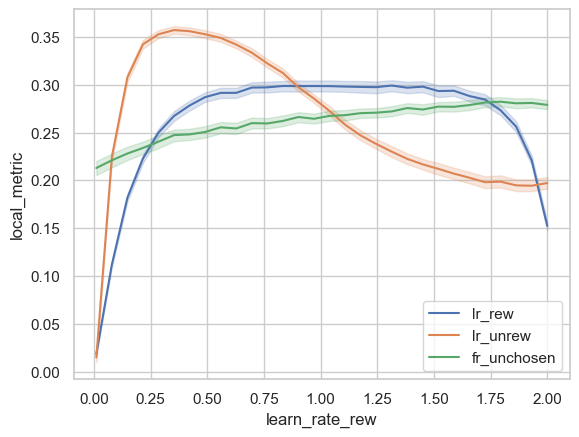

In [58]:
sns.lineplot(results_df, x='learn_rate_rew', y='local_metric', label='lr_rew')
sns.lineplot(results_df, x='learn_rate_unrew', y='local_metric', label='lr_unrew')
sns.lineplot(results_df, x='forget_rate_unchosen', y='local_metric', label='fr_unchosen')

In [70]:
coupled_baiting_df = results_df[results_df['task_type'] == 'coupled_baited']
uncoupled_baiting_df = results_df[results_df['task_type'] == 'uncoupled_baited']
coupled_df = results_df[results_df['task_type'] == 'coupled_unbaited']
uncoupled_df = results_df[results_df['task_type'] == 'uncoupled_unbaited']


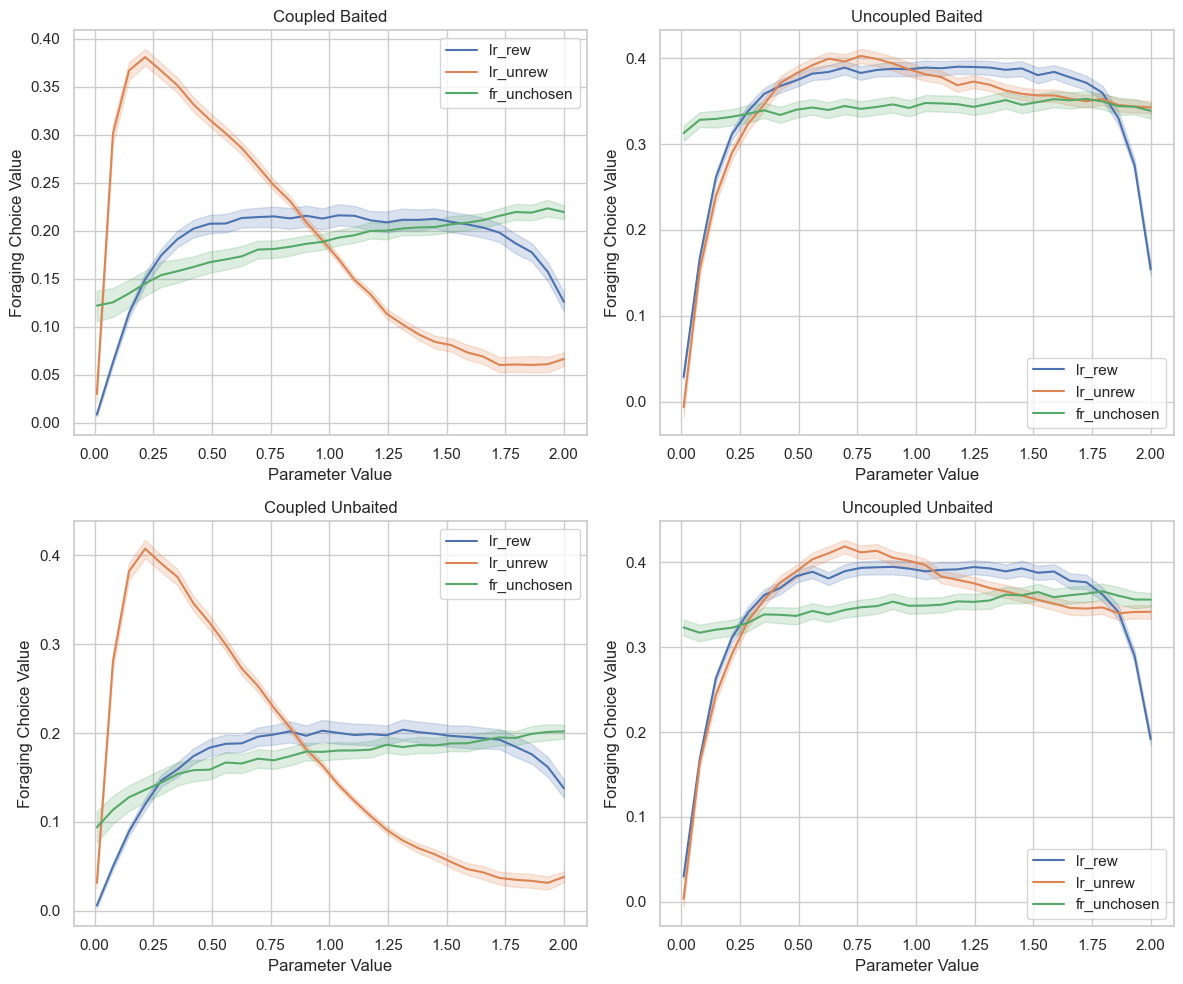

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

task_data = {
    (0,0): (coupled_baiting_df, 'Coupled Baited'),
    (0,1): (uncoupled_baiting_df, 'Uncoupled Baited'),
    (1,0): (coupled_df, 'Coupled Unbaited'),
    (1,1): (uncoupled_df, 'Uncoupled Unbaited')
}

for (i,j), (task_df, title) in task_data.items():
    sns.lineplot(data=task_df, x='learn_rate_rew', y='local_metric', 
                label='lr_rew', ax=axes[i,j])
    sns.lineplot(data=task_df, x='learn_rate_unrew', y='local_metric', 
                label='lr_unrew', ax=axes[i,j])
    sns.lineplot(data=task_df, x='forget_rate_unchosen', y='local_metric', 
                label='fr_unchosen', ax=axes[i,j])

    axes[i,j].set_title(title)
    axes[i,j].set_xlabel('Parameter Value')
    axes[i,j].set_ylabel('Foraging Choice Value')
    axes[i,j].legend()

plt.tight_layout()
plt.show()

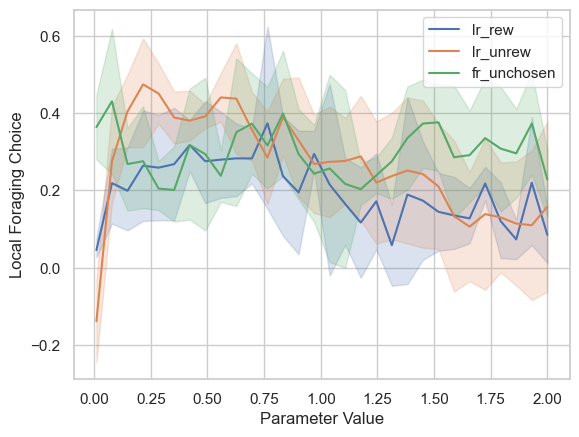

In [59]:
sns.lineplot(rew_lr_df, x='learn_rate_rew', y='local_metric', label='lr_rew')
sns.lineplot(unrew_lr_df, x='learn_rate_unrew', y='local_metric', label='lr_unrew')
sns.lineplot(fr_unchosen_df, x='forget_rate_unchosen', y='local_metric', label='fr_unchosen')
plt.xlabel('Parameter Value')
plt.ylabel('Local Foraging Choice')
plt.legend()
plt.show()

<Axes: xlabel='learn_rate_rew', ylabel='foraging_efficiency'>

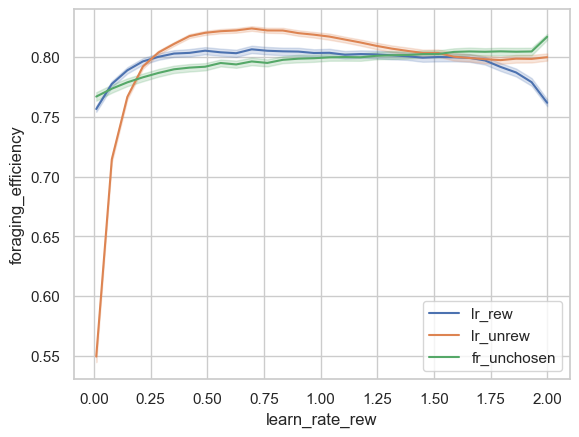

In [80]:
sns.lineplot(results_df, x='learn_rate_rew', y='foraging_efficiency', label='lr_rew')
sns.lineplot(results_df, x='learn_rate_unrew', y='foraging_efficiency', label='lr_unrew')
sns.lineplot(results_df, x='forget_rate_unchosen', y='foraging_efficiency', label='fr_unchosen')


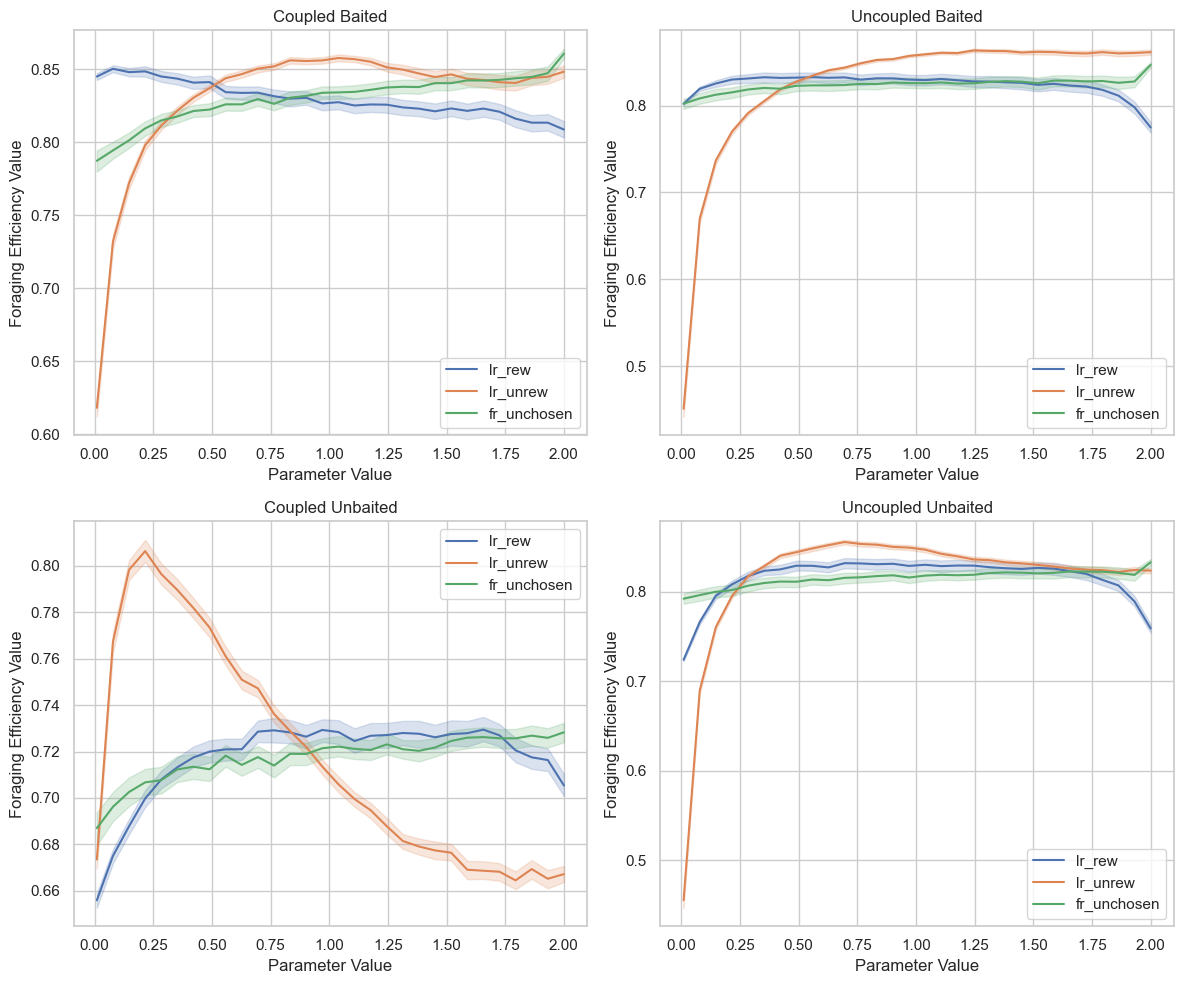

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for (i,j), (task_df, title) in task_data.items():
    sns.lineplot(data=task_df, x='learn_rate_rew', y='foraging_efficiency', 
                label='lr_rew', ax=axes[i,j])
    sns.lineplot(data=task_df, x='learn_rate_unrew', y='foraging_efficiency', 
                label='lr_unrew', ax=axes[i,j])
    sns.lineplot(data=task_df, x='forget_rate_unchosen', y='foraging_efficiency', 
                label='fr_unchosen', ax=axes[i,j])
    
    axes[i,j].set_title(title)
    axes[i,j].set_xlabel('Parameter Value')
    axes[i,j].set_ylabel('Foraging Efficiency Value')
    axes[i,j].legend()

plt.tight_layout()
plt.show()

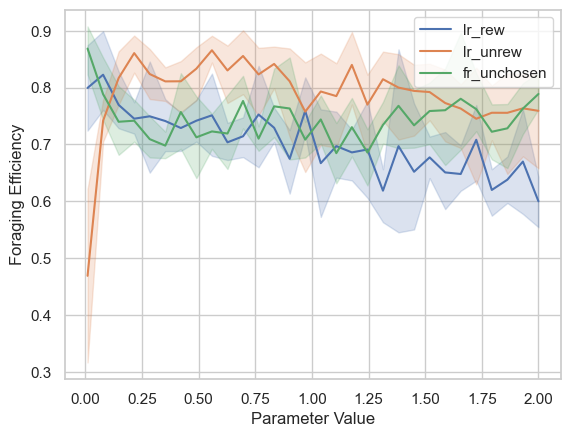

In [61]:
sns.lineplot(rew_lr_df, x='learn_rate_rew', y='foraging_efficiency', label='lr_rew')
sns.lineplot(unrew_lr_df, x='learn_rate_unrew', y='foraging_efficiency', label='lr_unrew')
sns.lineplot(fr_unchosen_df, x='forget_rate_unchosen', y='foraging_efficiency', label='fr_unchosen')
plt.xlabel('Parameter Value')
plt.ylabel('Foraging Efficiency')
plt.legend()
plt.show()


                local_metric  global_metric
learn_rate_rew                             
0.010000            0.018368       0.007646
0.078621            0.111943       0.066056
0.147241            0.181834       0.109764
0.215862            0.222905       0.134612
0.284483            0.250019       0.151813
0.353103            0.267392       0.162791
0.421724            0.278351       0.169475
0.490345            0.287084       0.175261
0.558966            0.291511       0.176725
0.627586            0.291585       0.177100
0.696207            0.297083       0.180395
0.764828            0.297311       0.180649
0.833448            0.298743       0.180832
0.902069            0.298621       0.181270
0.970690            0.298676       0.181050
1.039310            0.298582       0.180043
1.107931            0.298110       0.180791
1.176552            0.297773       0.179656
1.245172            0.297517       0.179850
1.313793            0.299226       0.179948
1.382414            0.296946    

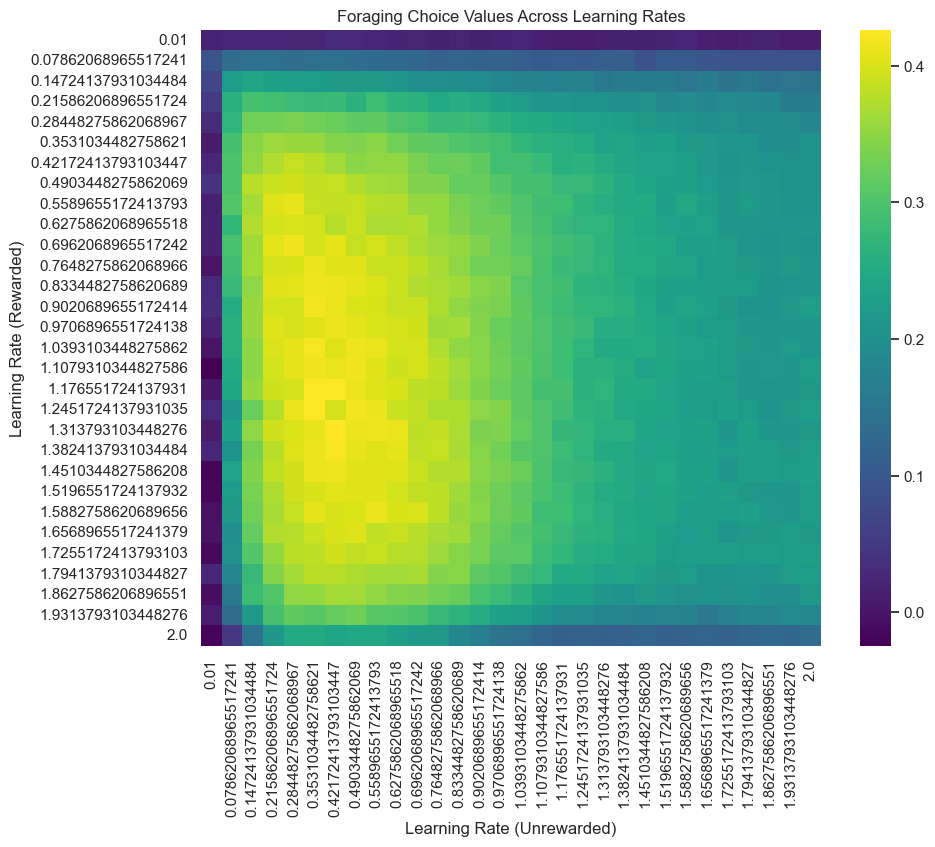

In [69]:
# Basic analysis of results

print(results_df.groupby('learn_rate_rew')[['local_metric', 'global_metric']].mean())

# Example heatmap for learn_rate_rew vs learn_rate_unrew (averaging over forget_rate)
pivot_table = results_df.pivot_table(
    values='local_metric', 
    index='learn_rate_rew',
    columns='learn_rate_unrew',
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='viridis')
plt.title('Foraging Choice Values Across Learning Rates')
plt.xlabel('Learning Rate (Unrewarded)')
plt.ylabel('Learning Rate (Rewarded)')
plt.show()

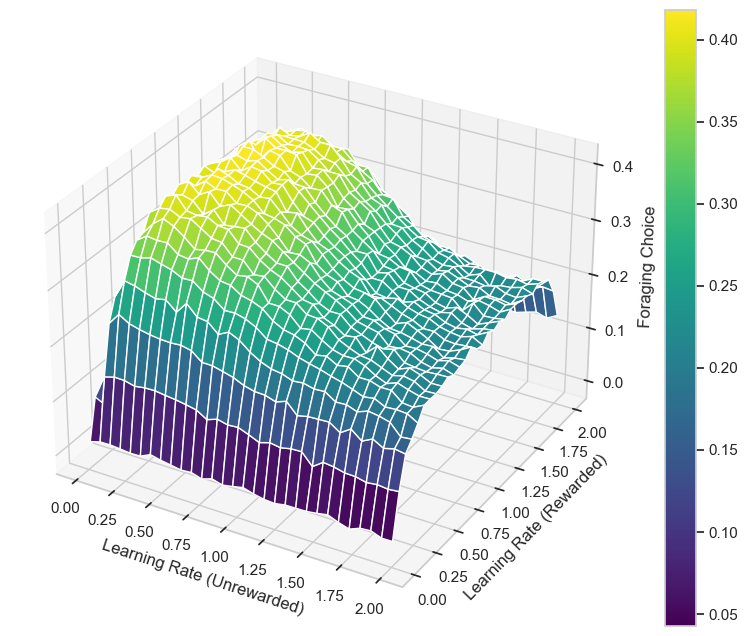

In [63]:
# Additional plots

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

pivot = results_df.pivot_table(
    values='local_metric',
    index='learn_rate_rew', 
    columns='learn_rate_unrew',
    aggfunc='mean'
)
X, Y = np.meshgrid(pivot.columns, pivot.index)

surf = ax.plot_surface(X, Y, pivot.values, cmap='viridis')
ax.set_xlabel('Learning Rate (Unrewarded)')
ax.set_ylabel('Learning Rate (Rewarded)') 
ax.set_zlabel('Foraging Choice')
plt.colorbar(surf)
plt.show()

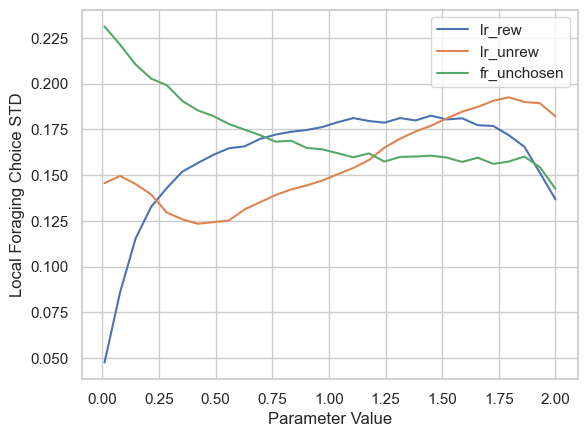

In [64]:
# Parameter sensitivity 
sensitivity_fc = pd.DataFrame({
    'learn_rate_rew': results_df.groupby('learn_rate_rew')['local_metric'].std(),
    'learn_rate_unrew': results_df.groupby('learn_rate_unrew')['local_metric'].std(),
    'forget_rate': results_df.groupby('forget_rate_unchosen')['local_metric'].std()
})

sns.lineplot(sensitivity_fc, x=sensitivity_fc.index, y='learn_rate_rew', label='lr_rew')
sns.lineplot(sensitivity_fc, x=sensitivity_fc.index, y='learn_rate_unrew', label='lr_unrew')
sns.lineplot(sensitivity_fc, x=sensitivity_fc.index, y='forget_rate', label='fr_unchosen')
plt.xlabel('Parameter Value')
plt.ylabel('Local Foraging Choice STD')
plt.legend()
plt.show()


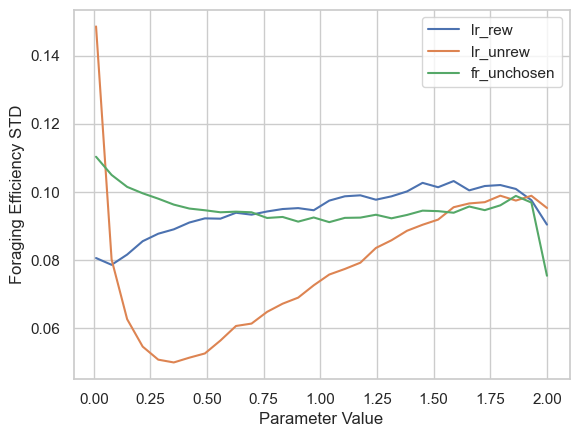

In [65]:
# Parameter sensitivity 
sensitivity_fe = pd.DataFrame({
    'learn_rate_rew': results_df.groupby('learn_rate_rew')['foraging_efficiency'].std(),
    'learn_rate_unrew': results_df.groupby('learn_rate_unrew')['foraging_efficiency'].std(),
    'forget_rate': results_df.groupby('forget_rate_unchosen')['foraging_efficiency'].std()
})

sns.lineplot(sensitivity_fe, x=sensitivity_fe.index, y='learn_rate_rew', label='lr_rew')
sns.lineplot(sensitivity_fe, x=sensitivity_fe.index, y='learn_rate_unrew', label='lr_unrew')
sns.lineplot(sensitivity_fe, x=sensitivity_fe.index, y='forget_rate', label='fr_unchosen')
plt.xlabel('Parameter Value')
plt.ylabel('Foraging Efficiency STD')
plt.legend()
plt.show()


In [66]:
# Parameter recovery 

# Fit model to recover parameters

forager.fit(
    choice_history,
    reward_history,
    fit_bounds_override = {'softmax_inverse_temperature': [0, 100]},
    clamp_params = {'biasL': 0},
    DE_kwargs = dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation = None,
)

fitting_results = forager.fitting_result

2024-12-16 13:21:29,827 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 222.13894707648677
differential_evolution step 2: f(x)= 217.07159744213934
differential_evolution step 3: f(x)= 200.62554060812232
differential_evolution step 4: f(x)= 200.62554060812232
differential_evolution step 5: f(x)= 200.62554060812232
differential_evolution step 6: f(x)= 200.62554060812232
differential_evolution step 7: f(x)= 200.62554060812232
differential_evolution step 8: f(x)= 199.2766809244615
differential_evolution step 9: f(x)= 199.2766809244615
differential_evolution step 10: f(x)= 197.30607666120392
differential_evolution step 11: f(x)= 197.30607666120392
differential_evolution step 12: f(x)= 196.37827385638542
differential_evolution step 13: f(x)= 196.37827385638542
differential_evolution step 14: f(x)= 196.37827385638542
differential_evolution step 15: f(x)= 196.37827385638542
differential_evolution step 16: f(x)= 196.37827385638542
differential_evolution step 17: f(x)= 196.37827385638542
differential_evolution step 18: f(x)= 196.

In [67]:
# Check fitted parameters 
fit_names = fitting_results.fit_settings['fit_names']
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f'Num of trials: {len(choice_history)}')
print(f'Fitted parameters: {fit_names}')
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_results.x]}')
print(f"Likelihood-Per-Trial: {fitting_results.LPT}")
print(f"Prediction accuracy full dataset: {fitting_results.prediction_accuracy}\n")

Num of trials: 1000
Fitted parameters: ['learn_rate_rew', 'learn_rate_unrew', 'forget_rate_unchosen', 'softmax_inverse_temperature']
Ground truth: ['0.6011', '0.1087', '0.1544', '4.8908']
Fitted:       ['0.4470', '0.1307', '0.0996', '6.7924']
Likelihood-Per-Trial: 0.8218066961956254
Prediction accuracy full dataset: 0.933



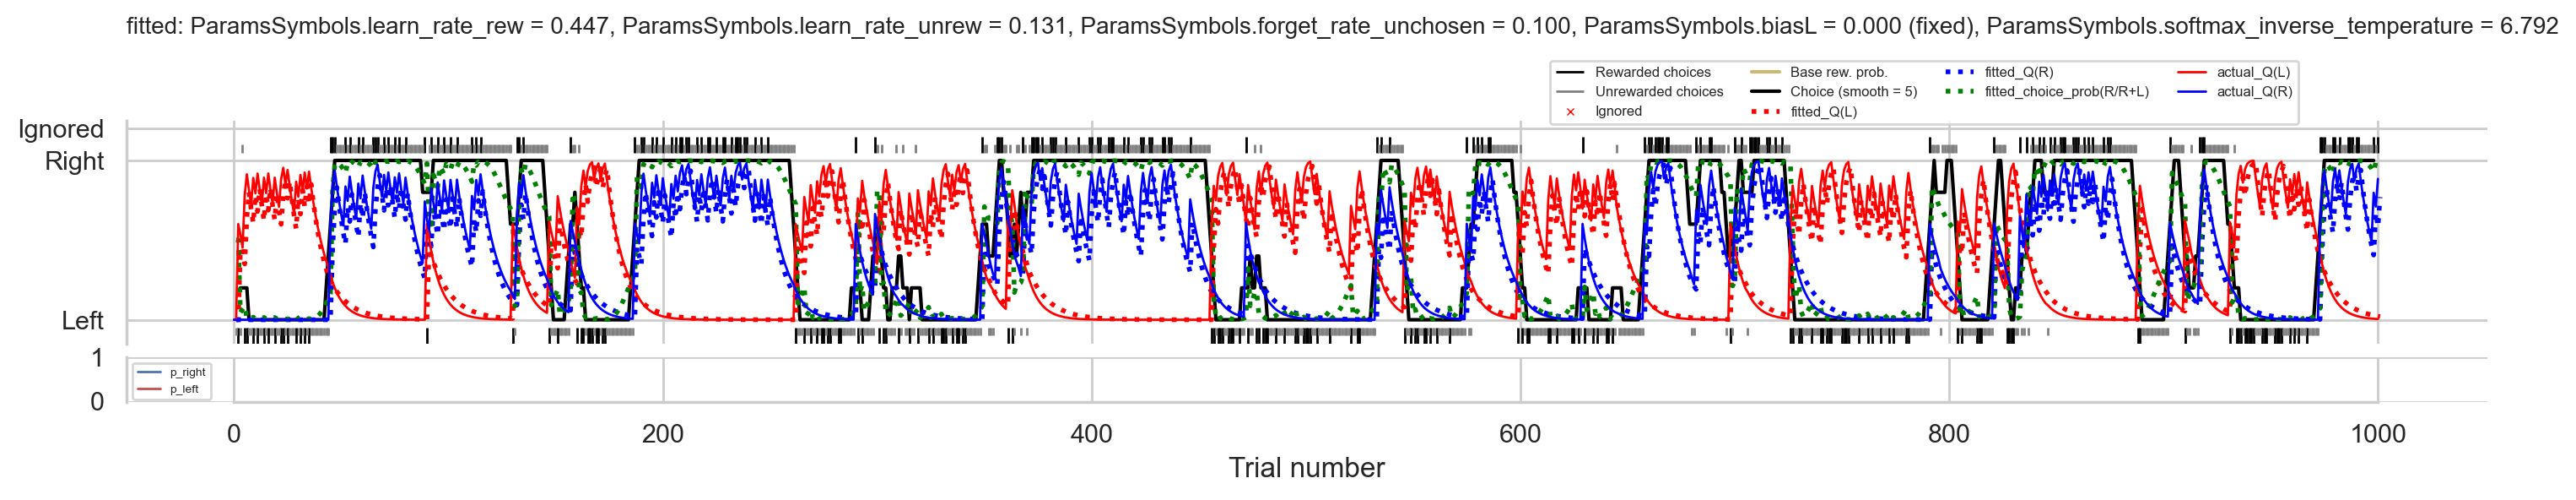

In [68]:
# Plot fitted session results

fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

# Overlay ground truth Q values
axes[0].plot(ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
axes[0].plot(ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)